In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Efficient PyTorch Training on Vertex AI

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/community-content/pytorch_efficient_training/efficient_pytorch_training_on_vertex.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/community-content/pytorch_efficient_training/efficient_pytorch_training_on_vertex.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/community-content/pytorch_efficient_training/efficient_pytorch_training_on_vertex.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This tutorial demonstrates how to use Vertex AI for E2E MLOps on Google Cloud in production. This tutorial covers stage 2 : experimentation: get started with Vertex AI Training for PyTorch.

### Objective

In this tutorial, you learn how to use `Vertex AI Training` for training a PyTorch custom model.

This tutorial uses the following Google Cloud ML services:

* `Vertex AI Training`
* `Vertex AI Model` resource


The steps performed include:

- Single node training using a Python package.
- Report accuracy when hyperparameter tuning.
- Save the model artifacts to Cloud Storage using GCSFuse.
- Create a `Vertex AI Model` resource.

### Dataset

The dataset used for this tutorial is the [CIFAR10 dataset](https://pytorch.org/vision/stable/datasets.html#cifar) from [PyTorch Datasets](https://pytorch.org/vision/stable/datasets.html). The version of the dataset is built into TensorFlow. The trained model predicts which type of class an image is from ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck.

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

## Installations

Install the following packages to execute this notebook.

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG -q
! pip3 install --upgrade cloudml-hypertune $USER_FLAG -q
! pip3 install --upgrade torchvision $USER_FLAG -q

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, BigQuery, Compute Engine and Cloud Storage APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,bigquery,compute_component,storage_component).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [ ]:
! gcloud config set project $PROJECT_ID

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

1. **Click Create service account**.

2. In the **Service account name** field, enter a name, and click **Create**.

3. In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex AI" into the filter box, and select **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

4. Click Create. A JSON file that contains your key downloads to your local environment.

5. Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = False
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        IS_COLAB = True
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
BUCKET_URI = "gs://[your-bucket-name]"  # @param {type:"string"}

In [ ]:
if BUCKET_URI == "" or BUCKET_URI is None or BUCKET_URI == "gs://[your-bucket-name]":
    BUCKET_URI = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [1]:
PROJECT_ID = 'rthallam-demo-project'  # Change to your project ID
REGION = 'us-central1'   # Change to your region (example: us-central1)
BUCKET_NAME = 'cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77'  # Change to your bucket name

In [2]:
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [3]:
from datetime import datetime

def get_timestamp():
    """return formatted date/time"""
    return datetime.now().strftime("%Y%m%d%H%M%S")

In [4]:
SERVICE_ACCOUNT = "[your-service-account]" 

if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()
    print("Servcie Account: ", SERVICE_ACCOUNT)

Servcie Account:  560224572293-compute@developer.gserviceaccount.com


In [5]:
import google.cloud.aiplatform as aiplatform
import pandas as pd

### Create a TensorBoard instance to be used by the custom training job.

In [7]:
TENSORBOARD_NAME = EXPERIMENT_NAME  # @param {type:"string"}

tb_list = aiplatform.Tensorboard.list(
    filter=f'displayName="{TENSORBOARD_NAME}"',
    project=PROJECT_ID, 
    location=REGION
)

if len(tb_list) == 0:
    tensorboard = aiplatform.Tensorboard.create(
        display_name=TENSORBOARD_NAME, 
        project=PROJECT_ID, 
        location=REGION
    )

    TENSORBOARD_RESOURCE_NAME = tensorboard.gca_resource.name
    print("TensorBoard resource name:", TENSORBOARD_RESOURCE_NAME)
else:
    TENSORBOARD_RESOURCE_NAME = tb_list[0].to_dict()['name']
    print("There is an existing TensorBoard resource with TENSORBOARD_RESOURCE_NAME:", TENSORBOARD_RESOURCE_NAME)

There is an existing TensorBoard resource with TENSORBOARD_RESOURCE_NAME: projects/560224572293/locations/us-central1/tensorboards/3120792231628242944


### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [105]:
EXPERIMENT_NAME = "pytorch-efficient-training-test"
aiplatform.init(project=PROJECT_ID,
                location=REGION,
                experiment=EXPERIMENT_NAME,
                experiment_tensorboard=TENSORBOARD_RESOURCE_NAME,
                staging_bucket=BUCKET_URI)

#### Set hardware accelerators

You can set hardware accelerators for training.

Set the variable `TRAIN_GPU/TRAIN_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Telsa K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

Otherwise specify `(None, None)` to use a container image to run on a CPU.

Learn more [here](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators) hardware accelerator support for your region

In [79]:
TRAIN_GPU, TRAIN_NGPU = (aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_T4, 4)

#### Set pre-built containers

Set the pre-built Docker container image for training.

- Set the variable `TF` to the TensorFlow version of the container image. For example, `2-1` would be version 2.1, and `1-15` would be version 1.15. The following list shows some of the pre-built images available:


For the latest list, see [Pre-built containers for training](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers).

In [9]:
TRAIN_VERSION = "pytorch-gpu.1-11"
TRAIN_IMAGE = "{}-docker.pkg.dev/vertex-ai/training/{}:latest".format(
    REGION.split("-")[0], TRAIN_VERSION
)

#### Set machine type

Next, set the machine type to use for training.

- Set the variable `TRAIN_COMPUTE` to configure  the compute resources for the VMs you will use for for training.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU.
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [10]:
MACHINE_TYPE = "n1-standard"
VCPU = "8"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

Train machine type n1-standard-8


## Introduction to PyTorch training

The PyTorch package supports both single node and distributed model training.

Once you have trained a PyTorch model, you will want to save it at a Cloud Storage location, so it can subsequently be uploaded to a `Vertex AI Model` resource.
The PyTorch package does not have support to save the model to a Cloud Storage location. Instead, you will do the following steps to save to a Cloud Storage location.

1. Save the in-memory model to the local filesystem (e.g., model.pth).
2. Use gsutil to copy the local copy to the specified Cloud Storage location.

*Note*: You can do hyperparameter tuning with a PyTorch model.

### Examine the training package

#### Package layout

Before you start the training, you will look at how a Python package is assembled for a custom training job. When unarchived, the package contains the following directory/file layout.

- PKG-INFO
- README.md
- setup.cfg
- setup.py
- trainer
  - \_\_init\_\_.py
  - task.py

The files `setup.cfg` and `setup.py` are the instructions for installing the package into the operating environment of the Docker image.

The file `trainer/task.py` is the Python script for executing the custom training job. *Note*, when we referred to it in the worker pool specification, we replace the directory slash with a dot (`trainer.task`) and dropped the file suffix (`.py`).

#### Package Assembly

In the following cells, you will assemble the training package.

In [ ]:
# Make folder for Python training script
! tree

In [ ]:
! cat custom/setup.py

### Create the task script for the Python training package

Next, you create the `task.py` script for driving the training package. Some noteable steps include:

- Command-line arguments:
    - `model-dir`: The location to save the trained model. When using Vertex AI custom training, the location will be specified in the environment variable: `AIP_MODEL_DIR`,
    - `batch_size`/`lr` : Hyperparameter tuning variables
    - `distribute`: single node or distributed training.
- Data preprocessing (`get_data()`):
    - Download the dataset and split into training and test.
- Model architecture (`getmodel()`):
    - Get or build the model architecture.
- Training (`train_model()`):
    - Trains the model
- Evaluation (`evaluate_model()`):
    - Evaluates the model.
    - If hyperparameter tuning, reports the metric for accuracy.
- Model artifact saving
    - Saves the model artifacts and evaluation metrics where the Cloud Storage location specified by `model-dir`.

In [ ]:
! cat trainer/main.py

### Test training package locally

Next, test your completed training package locally with just a few epochs.

In [ ]:
! export WDS_TRAIN_PATH="/home/jupyter/data/imagenet/imagenet-shards/train-{000020..000039}.tar" && \
  export WDS_EVAL_PATH="/home/jupyter/data/imagenet/imagenet-shards/validation-{000000..000021}.tar" && \
  export PYTHONPATH="${PYTHONPATH}:${PWD}/custom/" && \
  python -m trainer.main \
    --train_data_path ${WDS_TRAIN_PATH} \
    --val_data_path ${WDS_EVAL_PATH} \
    --distributed-strategy=ddp \
    --webdataset \
    --epochs=2

#### Preparing container with training script

In [11]:
%%writefile Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-11:latest

COPY ./custom /custom

WORKDIR /custom

RUN pip install -r requirements.txt

# Set up the entry point to invoke the trainer.
ENTRYPOINT ["python", "-m", "trainer.main"]

Overwriting Dockerfile


In [12]:
CUSTOM_TRAIN_IMAGE_URI = f"gcr.io/{PROJECT_ID}/pytorch_eff_training"
CUSTOM_TRAIN_IMAGE_URI

'gcr.io/rthallam-demo-project/pytorch_eff_training'

In [ ]:
!gcloud builds submit \
   --region $REGION \
   --tag $CUSTOM_TRAIN_IMAGE_URI \
   --timeout "2h" \
   --machine-type=e2-highcpu-32 \
   .

#### Store training script on your Cloud Storage bucket

Next, you package the training folder into a compressed tar ball, and then store it in your Cloud Storage bucket.

In [ ]:
TRAIN_VERSION = "pytorch-gpu.1-9"
TRAIN_IMAGE = "{}-docker.pkg.dev/vertex-ai/training/{}:latest".format(
    REGION.split("-")[0], TRAIN_VERSION
)

In [ ]:
python_package_gcs_uri = f"{BUCKET_URI}/experiments/pytorch_eff_training/scripts/trainer_imagenet.tar.gz"    
python_module_name = "trainer.main"

In [ ]:
! rm -f custom.tar.gz
! tar --exclude="__pycache__" --exclude=".ipynb_checkpoints" -czvf custom.tar.gz custom
! gsutil cp custom.tar.gz $python_package_gcs_uri

In [ ]:
! tar tvf custom.tar.gz

## Creating filestore instance as NFS mount

In [50]:
! gcloud services enable file.googleapis.com
! gcloud services enable servicenetworking.googleapis.com 

PROJECT_NUMBER=!gcloud projects list --filter="project_id:$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUMBER=str(PROJECT_NUMBER).strip('[').strip(']').strip("'")

FILESTORE_ID='nfs-imagenet'
FILE_SHARE_NAME= 'data' #@param {type:"string"}
ZONE='us-central1-a' #@param {type:"string"}
NETWORK=f'projects/{PROJECT_NUMBER}/global/networks/default'

# This is for display only; you can name the range anything.
PEERING_RANGE_NAME = "google-reserved-range"

In [51]:
# NOTE: `prefix-length=16` means a CIDR block with mask /16 will be
# reserved for use by Google services, such as Vertex AI.
!gcloud compute addresses create google-reserved-range \
  --global \
  --prefix-length=16 \
  --description="peering range for Google service" \
  --network=default \
  --purpose=VPC_PEERING

ERROR: (gcloud.compute.addresses.create) Could not fetch resource:
 - The resource 'projects/rthallam-demo-project/global/addresses/google-reserved-range' already exists



In [ ]:
# Create the VPC connection.
!gcloud services vpc-peerings connect \
  --service=servicenetworking.googleapis.com \
  --network=default \
  --ranges=google-reserved-range \
  --project=rthallam-demo-project

In [55]:
############# Create a Filestore Instance ############
# See https://cloud.google.com/filestore/docs/creating-instances#instructions_for_creating_an_instance 
# for more details in case you want to use different flag values or specify extra configs.
# For network, please use full name and always PRIVATE_SERVICE_ACCESS mode.
! gcloud filestore instances create {FILESTORE_ID} \
    --location={REGION}-a \
    --tier=basic-ssd \
    --file-share=name={FILE_SHARE_NAME},capacity=2.5TB \
    --network=name={NETWORK},connect-mode=PRIVATE_SERVICE_ACCESS

Waiting for [operation-1670824635970-5ef9b2ce8b1e9-dcd69560-c821f8e3] to finish
...done.                                                                       


In [73]:
# get IP address for mounting
FILESTORE_DESC = !gcloud filestore instances describe {FILESTORE_ID} \
    --project={PROJECT_ID} \
    --location={REGION}-a \
    --format='value(networks.ipAddresses)'
FILESTORE_IP_ADDRESS = FILESTORE_DESC[-1].translate( { ord(i): None for i in "'[]"} )
FILESTORE_IP_ADDRESS

'172.26.0.2'

In [90]:
!gcloud filestore instances describe {FILESTORE_ID} \
    --project={PROJECT_ID} \
    --location={REGION}-a

createTime: '2022-12-12T05:57:16.891770393Z'
fileShares:
- capacityGb: '2560'
  name: data
name: projects/rthallam-demo-project/locations/us-central1-a/instances/nfs-imagenet
networks:
- connectMode: PRIVATE_SERVICE_ACCESS
  ipAddresses:
  - 172.26.0.2
  network: projects/560224572293/global/networks/default
  reservedIpRange: 172.26.0.0/29
state: READY
tier: BASIC_SSD


In [74]:
print(f'sudo mkdir -p ~/{FILE_SHARE_NAME}')
print(f'sudo mount -o rw,intr {FILESTORE_IP_ADDRESS}:/{FILE_SHARE_NAME} ~/{FILE_SHARE_NAME}')

sudo mkdir -p ~/data
sudo mount -o rw,intr 172.26.0.2:/data ~/data


In [ ]:
! sudo mkdir -p mount-point-directory

### Create and run custom training job


To train a custom model, you perform two steps: 1) create a custom training job, and 2) run the job.

#### Create custom training job

A custom training job is created with the `CustomTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the custom training job.
- `container_uri`: The training container image.

- `python_package_gcs_uri`: The location of the Python training package as a tarball.
- `python_module_name`: The relative path to the training script in the Python package.
- `model_serving_container_uri`: The container image for deploying the model.

*Note:* There is no requirements parameter. You specify any requirements in the `setup.py` script in your Python package.

In [ ]:
%%writefile custom/copy_to_local.sh
#!/bin/bash -xv
echo "Copying data from "$1" to /data"
mkdir -p data
gcloud storage cp --recursive $1 ~/data/

In [ ]:

job = aiplatform.CustomPythonPackageTrainingJob(
    display_name=DISPLAY_NAME,
    python_package_gcs_uri=python_package_gcs_uri,
    python_module_name=python_module_name,
    container_uri=TRAIN_IMAGE,
    staging_bucket=BUCKET_URI
)

### Prepare your command-line arguments

Now define the command-line arguments for your custom training container:

- `args`: The command-line arguments to pass to the executable that is set as the entry point into the container.
  - `--model-dir` : For our demonstrations, we use this command-line argument to specify where to store the model artifacts.
      - direct: You pass the Cloud Storage location as a command line argument to your training script (set variable `DIRECT = True`), or
      - indirect: The service passes the Cloud Storage location as the environment variable `AIP_MODEL_DIR` to your training script (set variable `DIRECT = False`). In this case, you tell the service the model artifact location in the job specification.
  - `--BLAH`:

In [38]:
# Set command line parameters for training job

DISPLAY_NAME = "pytorch_imagenet_eff_" + get_timestamp()

REPLICA_COUNT = 1
BATCH_SIZE = 32
EPOCHS = 5
WDS_TRAIN_PATH = '/gcs/rt-image-datasets/data/images/imagenet/imagenet_tar/train-{000020..000039}.tar' 
WDS_EVAL_PATH = '/gcs/rt-image-datasets/data/images/imagenet/imagenet_tar/validation-{000000..000021}.tar'
BASE_OUTPUT_DIR = f'{BUCKET_URI}/experiments/pytorch_eff_training/runs/{DISPLAY_NAME}/'
DIST_STRATEGY = 'na'
WEBDATASET = True
REDUCTION_SERVER = False

CMDARGS = [
    f'--train_data_path', f'{WDS_TRAIN_PATH}',
    f'--val_data_path', f'{WDS_EVAL_PATH}', 
    f'--distributed-strategy', f'{DIST_STRATEGY}',
    f'--gpus', f'{TRAIN_NGPU}',
    f'--batch-size', f'{BATCH_SIZE}',
    f'--epoch', f'{EPOCHS}',
    f'--webdataset' if WEBDATASET else ''
]


print(f"CMD_ARGS \n{chr(10).join(CMDARGS)}")
print(f"BASE_OUTPUT_DIR = {BASE_OUTPUT_DIR}")

CMD_ARGS 
--train_data_path
/gcs/rt-image-datasets/data/images/imagenet/imagenet_tar/train-{000020..000039}.tar
--val_data_path
/gcs/rt-image-datasets/data/images/imagenet/imagenet_tar/validation-{000000..000021}.tar
--distributed-strategy
na
--gpus
1
--batch-size
32
--epoch
5
--webdataset
BASE_OUTPUT_DIR = gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212045823/


In [42]:
# Set experiment parameters
exp_params = {
    'Replica Count': REPLICA_COUNT,
    'Number of GPU': TRAIN_NGPU,
    'Batch Size': BATCH_SIZE,
    'Epochs': EPOCHS,
    # variables
    'Strategy': DIST_STRATEGY,
    'WebDataset': 'Y' if WEBDATASET else 'N',
    'Reduction Server': 'Y' if REDUCTION_SERVER else 'N',
    'Storage': 'gcsfuse' # local, nfs
}


EXPERIMENT_RUN_NAME = (exp_params["Strategy"] +
                       ("-wds" if WEBDATASET else "") +
                       ("-gcsfuse" if WDS_TRAIN_PATH.startswith("/gcs") else "") +
                       ("-reductionserver" if REDUCTION_SERVER else "")
                      )
print(f"EXPERIMENT_RUN_NAME = {EXPERIMENT_RUN_NAME}")
exp_params

EXPERIMENT_RUN_NAME = na-wds-gcsfuse


{'Replica Count': 1,
 'Number of GPU': 1,
 'Batch Size': 32,
 'Epochs': 5,
 'Strategy': 'na',
 'WebDataset': 'Y',
 'Reduction Server': 'N',
 'Storage': 'gcsfuse'}

#### Run the custom training job

Next, you run the custom job to start the training job by invoking the method `run`, with the following parameters:

- `model_display_name`: The human readable name for the `Model` resource.
- `args`: The command-line arguments to pass to the training script.
- `replica_count`: The number of compute instances for training (replica_count = 1 is single node training).
- `machine_type`: The machine type for the compute instances.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `base_output_dir`: The Cloud Storage location to write the model artifacts to.
- `sync`: Whether to block until completion of the job.

In [43]:
aiplatform.start_run(EXPERIMENT_RUN_NAME)

# log parameters to the experiment
aiplatform.log_params(exp_params)

# create job
job = aiplatform.CustomContainerTrainingJob(
    display_name=DISPLAY_NAME, 
    container_uri=CUSTOM_TRAIN_IMAGE_URI,
    staging_bucket=BUCKET_URI
)

# submit job
job.run(
    args=CMDARGS,
    replica_count=1,
    machine_type=TRAIN_COMPUTE,
    boot_disk_type='pd-ssd',
    boot_disk_size_gb=100,
    accelerator_type=TRAIN_GPU.name,
    accelerator_count=TRAIN_NGPU,
    base_output_dir=BASE_OUTPUT_DIR,
    service_account=SERVICE_ACCOUNT,
    tensorboard=TENSORBOARD_RESOURCE_NAME,
    sync=True,
)

if job.state.value == 4 :
    # log metrics to the experiment
    metrics_path = f'{BASE_OUTPUT_DIR}checkpoints/metrics/summary_metrics.json'
    metrics_cols = ['train_time', 'eval_time', 'data_load_time', 'data_througput']
    metrics_df = pd.read_json(metrics_path, typ='series')
    aiplatform.log_metrics(metrics_df[metrics_cols].to_dict())


aiplatform.end_run()

Associating projects/560224572293/locations/us-central1/metadataStores/default/contexts/pytorch-efficient-training-test-na-wds-gcsfuse to Experiment: pytorch-efficient-training-test
Training Output directory:
gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212045823/ 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/6540445055264489472?project=560224572293
CustomContainerTrainingJob projects/560224572293/locations/us-central1/trainingPipelines/6540445055264489472 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5393645631401099264?project=560224572293
View tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+560224572293+locations+us-central1+tensorboards+3120792231628242944+experiments+5393645631401099264
CustomContainerTrainingJob p

#### Compare the experiment results

In [112]:
experiment_df = aiplatform.get_experiment_df()
cols = ['run_name', 
        'param.Storage' , 'param.Strategy', 'param.WebDataset', 
        #'param.Reduction Server',
        'metric.train_time' 
        # , 'metric.data_througput'
       ]
experiment_df[cols].sort_values(['run_name'])

,run_name,param.Storage,param.Strategy,param.WebDataset,metric.train_time
6,ddp-wds-gcsfuse,NaN,ddp,Y,119.211
2,ddp-wds-nfs,nfs,ddp,Y,112.309
4,dp-wds-gcsfuse,gcsfuse,dp,Y,155.214
0,dp-wds-nfs,nfs,dp,Y,156.736
5,fsdp-wds-gcsfuse,gcsfuse,fsdp,Y,150.825
1,fsdp-wds-nfs,nfs,fsdp,Y,147.118
3,na-wds-gcsfuse,gcsfuse,na,Y,225.544


### List a custom training job

In [ ]:
_job = job.list(filter=f"display_name={DISPLAY_NAME}")
print(_job)

### Wait for completion of custom training job

Next, wait for the custom training job to complete. Alternatively, one can set the parameter `sync` to `True` in the `run()` method to block until the custom training job is completed.

In [ ]:
model.wait()

### Delete a custom training job

After a training job is completed, you can delete the training job with the method `delete()`.  Prior to completion, a training job can be cancelled with the method `cancel()`.

In [ ]:
job.delete()

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- Cloud Storage Bucket

In [ ]:
# Delete the model using the Vertex model object
model.delete()

delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

---

In [113]:
TRAIN_GPU, TRAIN_NGPU = (aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_T4, 1)

In [114]:
DISPLAY_NAME = "pytorch_imagenet_eff_" + get_timestamp()

REPLICA_COUNT = 1
BATCH_SIZE = 32
EPOCHS = 5
WDS_TRAIN_PATH = '/mnt/nfs/data/imagenet/imagenet-shards/train-{000020..000039}.tar' 
WDS_EVAL_PATH = '/mnt/nfs/data/imagenet/imagenet-shards/validation-{000000..000021}.tar'
BASE_OUTPUT_DIR = f'{BUCKET_URI}/experiments/pytorch_eff_training/runs/{DISPLAY_NAME}/'
DIST_STRATEGY = 'na'
WEBDATASET = True
REDUCTION_SERVER = False

CMDARGS = [
    f'--train_data_path', f'{WDS_TRAIN_PATH}',
    f'--val_data_path', f'{WDS_EVAL_PATH}', 
    f'--distributed-strategy', f'{DIST_STRATEGY}',
    f'--gpus', f'{TRAIN_NGPU}',
    f'--batch-size', f'{BATCH_SIZE}',
    f'--epoch', f'{EPOCHS}',
    f'--webdataset' if WEBDATASET else ''
]


print(f"CMD_ARGS \n{chr(10).join(CMDARGS)}")
print(f"BASE_OUTPUT_DIR = {BASE_OUTPUT_DIR}")

CMD_ARGS 
--train_data_path
/mnt/nfs/data/imagenet/imagenet-shards/train-{000020..000039}.tar
--val_data_path
/mnt/nfs/data/imagenet/imagenet-shards/validation-{000000..000021}.tar
--distributed-strategy
na
--gpus
1
--batch-size
32
--epoch
5
--webdataset
BASE_OUTPUT_DIR = gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212140140/


In [115]:
# Set experiment parameters
exp_params = {
    'Replica Count': REPLICA_COUNT,
    'Number of GPU': TRAIN_NGPU,
    'Batch Size': BATCH_SIZE,
    'Epochs': EPOCHS,
    # variables
    'Strategy': DIST_STRATEGY,
    'WebDataset': 'Y' if WEBDATASET else 'N',
    'Reduction Server': 'Y' if REDUCTION_SERVER else 'N',
    'Storage': 'nfs' # local, nfs
}


EXPERIMENT_RUN_NAME = (exp_params["Strategy"] +
                       ("-wds" if WEBDATASET else "") +
                       ("-nfs") +
                       ("-reductionserver" if REDUCTION_SERVER else "")
                      )
print(f"EXPERIMENT_RUN_NAME = {EXPERIMENT_RUN_NAME}")
exp_params

EXPERIMENT_RUN_NAME = na-wds-nfs


{'Replica Count': 1,
 'Number of GPU': 1,
 'Batch Size': 32,
 'Epochs': 5,
 'Strategy': 'na',
 'WebDataset': 'Y',
 'Reduction Server': 'N',
 'Storage': 'nfs'}

In [116]:
WORKER_SPEC = [{
  "machine_spec": {
    "machine_type": TRAIN_COMPUTE,
    "accelerator_type": TRAIN_GPU.name,
    "accelerator_count": TRAIN_NGPU
  },
  "replica_count": 1,
  "nfs_mounts": [{
    "server": FILESTORE_IP_ADDRESS,
    "path": f'/{FILE_SHARE_NAME}',
    "mount_point": '/mnt/nfs/data',
  }],
  "container_spec": {
    "image_uri": CUSTOM_TRAIN_IMAGE_URI,
    "args": CMDARGS
  }
}]
WORKER_SPEC

[{'machine_spec': {'machine_type': 'n1-standard-8',
   'accelerator_type': 'NVIDIA_TESLA_T4',
   'accelerator_count': 1},
  'replica_count': 1,
  'nfs_mounts': [{'server': '172.26.0.2',
    'path': '/data',
    'mount_point': '/mnt/nfs/data'}],
  'container_spec': {'image_uri': 'gcr.io/rthallam-demo-project/pytorch_eff_training',
   'args': ['--train_data_path',
    '/mnt/nfs/data/imagenet/imagenet-shards/train-{000020..000039}.tar',
    '--val_data_path',
    '/mnt/nfs/data/imagenet/imagenet-shards/validation-{000000..000021}.tar',
    '--distributed-strategy',
    'na',
    '--gpus',
    '1',
    '--batch-size',
    '32',
    '--epoch',
    '5',
    '--webdataset']}}]

In [ ]:
aiplatform.start_run(EXPERIMENT_RUN_NAME)

# log parameters to the experiment
aiplatform.log_params(exp_params)

# create job
job = aiplatform.CustomJob(
    display_name=DISPLAY_NAME, 
    worker_pool_specs=WORKER_SPEC,
    staging_bucket=BUCKET_URI,
    base_output_dir=BASE_OUTPUT_DIR
)

job.run(
    service_account=SERVICE_ACCOUNT,
    network='projects/560224572293/global/networks/default',
    # tensorboard=TENSORBOARD_RESOURCE_NAME,
    sync=True
)

if job.state.value == 4 :
    # log metrics to the experiment
    metrics_path = f'{BASE_OUTPUT_DIR}checkpoints/metrics/summary_metrics.json'
    metrics_cols = ['train_time', 'eval_time', 'data_load_time', 'data_througput']
    metrics_df = pd.read_json(metrics_path, typ='series')
    aiplatform.log_metrics(metrics_df[metrics_cols].to_dict())


aiplatform.end_run()

In [ ]:
job.state

---

In [ ]:
import glob
import json
metrics_dir = 'tmp/checkpoints/metrics'

def display_metrics(metrics_dir):
    # collect all metrics
    metrics_f = glob.glob(f'{metrics_dir}/metrics_*.json')
    m = [json.load(open(f)) for f in metrics_f]
    print(json.dumps(m))
    len_m = len(m)
    m_totals = [item['total'] for item in m]
    m_0 = [item for item in m if item['gpu'] == 0][0]

    # inline functions
    get_metric = lambda meter,key: [item[key] for item in meter]
    avg = lambda items: sum(items)/len(items)

    # calculate summary
    m_summary = {
        'num_gpus': len_m, 
        'num_epochs': len(m_0['epoch']), 
        'train_time': round(avg(get_metric(m_totals, 'train_time')), 3), 
        'eval_time': round(avg(get_metric(m_totals, 'eval_time')), 3), 
        'data_load_time': round(avg(get_metric(m_totals, 'data_load_time')), 3), 
        'data_througput': round(sum(get_metric(m_totals, 'data_throughput')), 3), 
        'forward_time': round(avg(get_metric(m_totals, 'forward_time')), 3), 
        'backward_time': round(avg(get_metric(m_totals, 'backward_time')), 3), 
    }

    # display summary
    metrics_fmt = '\n=> '.join([f'{k} = {v}' for k,v in m_summary.items()])
    print('-'*80)
    print(f'=> {metrics_fmt}')
    print('-'*80)

display_metrics(metrics_dir)

In [ ]:
# TRAIN_VERSION = "pytorch-gpu.1-9"
# TRAIN_IMAGE = "{}-docker.pkg.dev/vertex-ai/training/{}:latest".format(
#     REGION.split("-")[0], TRAIN_VERSION
# )

# # create job
# DISPLAY_NAME = "pytorch_imagenet_eff_" + get_timestamp()
# python_module_name = "trainer.test"
# job = aiplatform.CustomPythonPackageTrainingJob(
#     display_name=DISPLAY_NAME,
#     python_package_gcs_uri=python_package_gcs_uri,
#     python_module_name=python_module_name,
#     container_uri=TRAIN_IMAGE,
#     staging_bucket=BUCKET_URI
# )

# # submit job
# job.run(
#     args=['&>', '${AIP_MODEL_DIR}/test.log'],
#     replica_count=1,
#     machine_type=TRAIN_COMPUTE,
#     boot_disk_type='pd-ssd',
#     boot_disk_size_gb=100,
#     accelerator_type=TRAIN_GPU.name,
#     accelerator_count=1,
#     base_output_dir=BASE_OUTPUT_DIR,
#     # service_account=SERVICE_ACCOUNT,
#     # tensorboard=TENSORBOARD_RESOURCE_NAME,
#     sync=False,
# )

In [ ]:
TRAIN_IMAGE

In [ ]:
# aiplatform.start_run(EXPERIMENT_RUN_NAME)

# # log parameters to the experiment
# aiplatform.log_params(exp_params)

# # create job
# DISPLAY_NAME = "pytorch_imagenet_eff_" + get_timestamp()
# job = aiplatform.CustomPythonPackageTrainingJob(
#     display_name=DISPLAY_NAME,
#     python_package_gcs_uri=python_package_gcs_uri,
#     python_module_name=python_module_name,
#     container_uri=TRAIN_IMAGE,
#     staging_bucket=BUCKET_URI
# )

# # submit job
# job.run(
#     args=CMDARGS,
#     replica_count=1,
#     machine_type=TRAIN_COMPUTE,
#     boot_disk_type='pd-ssd',
#     boot_disk_size_gb=100,
#     accelerator_type=TRAIN_GPU.name,
#     accelerator_count=TRAIN_NGPU,
#     base_output_dir=BASE_OUTPUT_DIR,
#     service_account=SERVICE_ACCOUNT,
#     tensorboard=TENSORBOARD_RESOURCE_NAME,
#     sync=True,
# )
# # job.wait_for_resource_creation()

# if job.state.value == 4 :
#     # log metrics to the experiment
#     metrics_path = f'{BASE_OUTPUT_DIR}checkpoints/metrics/summary_metrics.json'
#     metrics_cols = ['train_time', 'eval_time', 'data_load_time', 'data_througput']
#     metrics_df = pd.read_json(metrics_path, typ='series')
#     aiplatform.log_metrics(metrics_df[metrics_cols].to_dict())


# aiplatform.end_run()

In [18]:
from tensorboard.backend.event_processing import event_accumulator

In [22]:
!rm -fR logs

In [23]:
!gsutil cp -r gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212030542/logs .

Copying gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212030542/logs/events.out.tfevents.1670814693.f1a0f3cd3bbf.11.0...
Copying gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212030542/logs/events.out.tfevents.1670814693.f1a0f3cd3bbf.12.0...
Copying gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/experiments/pytorch_eff_training/runs/pytorch_imagenet_eff_20221212030542/logs/events.out.tfevents.1670814693.f1a0f3cd3bbf.13.0...
/ [3 files][  1.6 KiB/  1.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/ex

In [25]:
! ls -ltr logs

total 16
-rw-r--r-- 1 jupyter jupyter 1530 Dec 12 03:38 events.out.tfevents.1670814693.f1a0f3cd3bbf.11.0
-rw-r--r-- 1 jupyter jupyter   40 Dec 12 03:38 events.out.tfevents.1670814693.f1a0f3cd3bbf.12.0
-rw-r--r-- 1 jupyter jupyter   40 Dec 12 03:38 events.out.tfevents.1670814693.f1a0f3cd3bbf.13.0
-rw-r--r-- 1 jupyter jupyter   40 Dec 12 03:38 events.out.tfevents.1670814693.f1a0f3cd3bbf.14.0


    step              tag        value
0      1    Backward Time    92.600937
1      2    Backward Time    71.469337
2      3    Backward Time    72.210587
3      4    Backward Time    81.568993
4      5    Backward Time    77.389091
5      1   Data Load Time    10.897692
6      2   Data Load Time    14.815666
7      3   Data Load Time    15.557257
8      4   Data Load Time    13.182519
9      5   Data Load Time    16.663309
13     4  Data Throughput   949.135742
12     3  Data Throughput   804.254944
14     5  Data Throughput   750.871277
10     1  Data Throughput  1148.133057
11     2  Data Throughput   844.511414
15     1     Forward Time    26.173960
16     2     Forward Time    24.516863
17     3     Forward Time    23.960457
18     4     Forward Time    23.138754
19     5     Forward Time    23.681822
24     5             Loss  2398.791016
23     4             Loss  2464.773193
21     2             Loss  2615.734375
20     1             Loss  2746.109619
22     3             Loss

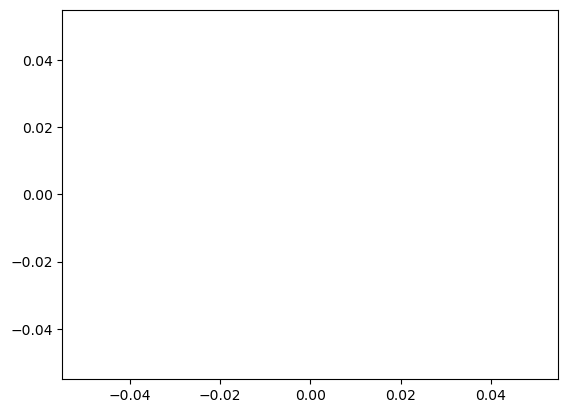

In [26]:
from tbparse import SummaryReader
log_dir = "logs"
reader = SummaryReader(log_dir)
df = reader.scalars
print(df.sort_values(['tag']))


import matplotlib.pyplot as plt
plt.plot(df['step'][df.tag=='Backward Time/0'], df['value'][df.tag=='Backward Time/0'])
plt.plot(df['step'][df.tag=='Data Throughput/0'], df['value'][df.tag=='Data Throughput/0'])

In [31]:
vars(ea.scalars)

{'_buckets': defaultdict(<function tensorboard.backend.event_processing.reservoir.Reservoir.__init__.<locals>.<lambda>()>,
             {}),
 '_mutex': <unlocked _thread.lock object at 0x7f2d85471a50>,
 'size': 10000,
 'always_keep_last': True}